---
## Data Collection Is Effective

At this point, it's clear I've been able to collect the right data from Chicago. We're going to assume the data is clean & correct for now. I may return to review later.

## Training and Testing

At this point it would be nice to create the training and testing data. We'll train on data from 2015 to 2021 (because I want to capture the peak from COVID). In the testing data, it would be ideal to accurately predict the protest activity in mid-2024. 

Let's pull the full data set, split it, and then see how it looks to continue and understand how we would build this model.

---

In [ ]:
# type the following to install the required packages into terminal
# conda activate civil_unrest
# gcloud init
# gcloud auth application-default login


zsh:1: command not found: gcloud
zsh:1: command not found: gcloud


In [19]:
# Import the necessary module
from google.cloud import bigquery
import pandas as pd
from matplotlib import pyplot as plt

In [18]:
# Initialize BigQuery client with the project ID
client = bigquery.Client(project="civil-unrest-predictor")

query = """
SELECT
    SQLDATE,
    EventCode,
    ActionGeo_FullName,
    ActionGeo_Lat,
    ActionGeo_Long,
    AvgTone
FROM
    `gdelt-bq.full.events`
WHERE
    EventCode IN ('145', '1451', '1452', '1453', '1454')
    AND ActionGeo_FullName LIKE '%Chicago%'
    AND CAST(SQLDATE AS STRING) >= '20150101'
ORDER BY
    SQLDATE DESC;
"""

# Execute the updated query
query_job = client.query(query)

# Convert results to a DataFrame
data = query_job.result().to_dataframe()

# Convert SQLDATE to datetime format
data['SQLDATE'] = pd.to_datetime(data['SQLDATE'], format='%Y%m%d')

# Split the data into training and testing datasets
train_data = data[data['SQLDATE'] < '2021-01-01']
test_data = data[data['SQLDATE'] >= '2021-01-01']

# Generate a date range from the start to the end of the test data
test_date_range = pd.date_range(start=test_data['SQLDATE'].min(), end=test_data['SQLDATE'].max())

# Reindex the grouped data to include all dates in the range, filling missing dates with 0 events
test_data = test_data.groupby('SQLDATE').size().reindex(test_date_range, fill_value=0)

# Generate a date range from the start to the end of the train data
train_date_range = pd.date_range(start=train_data['SQLDATE'].min(), end=train_data['SQLDATE'].max())

# Reindex the grouped data to include all dates in the range, filling missing dates with 0 events
train_data = train_data.groupby('SQLDATE').size().reindex(train_date_range, fill_value=0)

# Save the results to CSV files
train_data.to_csv("chicago_violent_protests_train.csv", index=False)
test_data.to_csv("chicago_violent_protests_test.csv", index=False)

print("Training data saved to 'chicago_violent_protests_train.csv'")
print("Testing data saved to 'chicago_violent_protests_test.csv'")
print("Training data:")
print(train_data.head())
print("Testing data:")
print(test_data.head())

ValueError: Please install the 'db-dtypes' package to use this function.

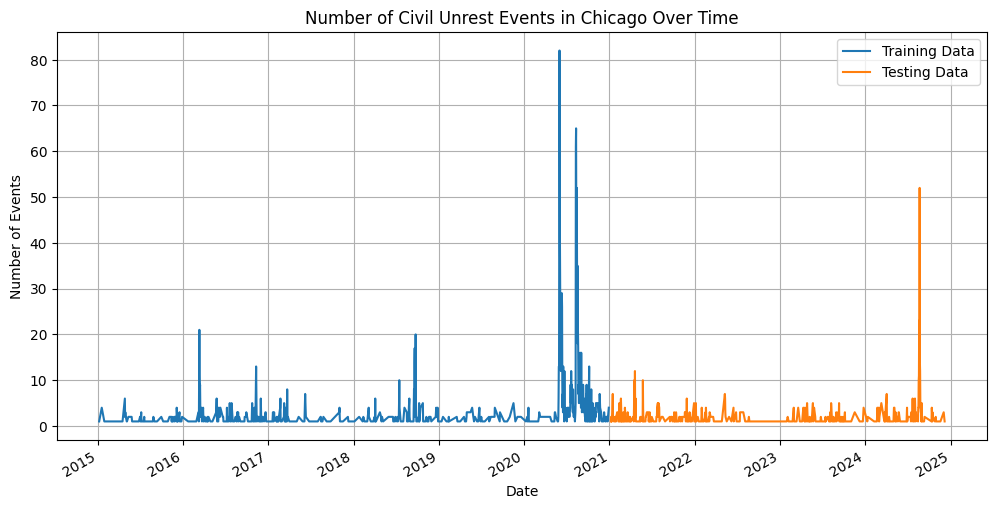

In [ ]:
# Plot the number of events over time for training and testing data
plt.figure(figsize=(12, 6))

# Plot training data
train_data.groupby('SQLDATE').size().plot(kind='line', label='Training Data')

# Plot testing data
test_data.groupby('SQLDATE').size().plot(kind='line', label='Testing Data')

plt.title('Number of Civil Unrest Events in Chicago Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Events')
plt.legend()
plt.grid(True)
plt.show()

---

## Comparisons with Research

### Let's see if these events show up in the data set

2015: Protests Following the Release of Laquan McDonald Video

In November 2015, the release of dashcam footage showing the police shooting of Laquan McDonald sparked widespread protests. Demonstrators blocked major intersections and disrupted shopping areas, leading to multiple arrests and instances of property damage. 

2020: George Floyd Protests

The death of George Floyd in May 2020 led to nationwide protests, with Chicago experiencing significant unrest. On May 31, the city recorded its deadliest day in at least 30 years, with 18 homicides within a 24-hour period. The violence coincided with protests that included rioting and looting, overwhelming the city's emergency response systems. 

2021: Protests Following the Killing of Adam Toledo

In April 2021, the police shooting of 13-year-old Adam Toledo resulted in protests throughout Chicago. While many demonstrations remained peaceful, there were instances of clashes between protesters and police, leading to arrests and injuries. 

2024: Democratic National Convention Protests

During the Democratic National Convention in August 2024, Chicago faced significant disruptions from pro-Palestinian protesters. These demonstrations led to confrontations with law enforcement and caused substantial disturbances in the city. 

These events highlight periods where protests in Chicago escalated into dangerous situations, impacting both public safety and city operations.

---

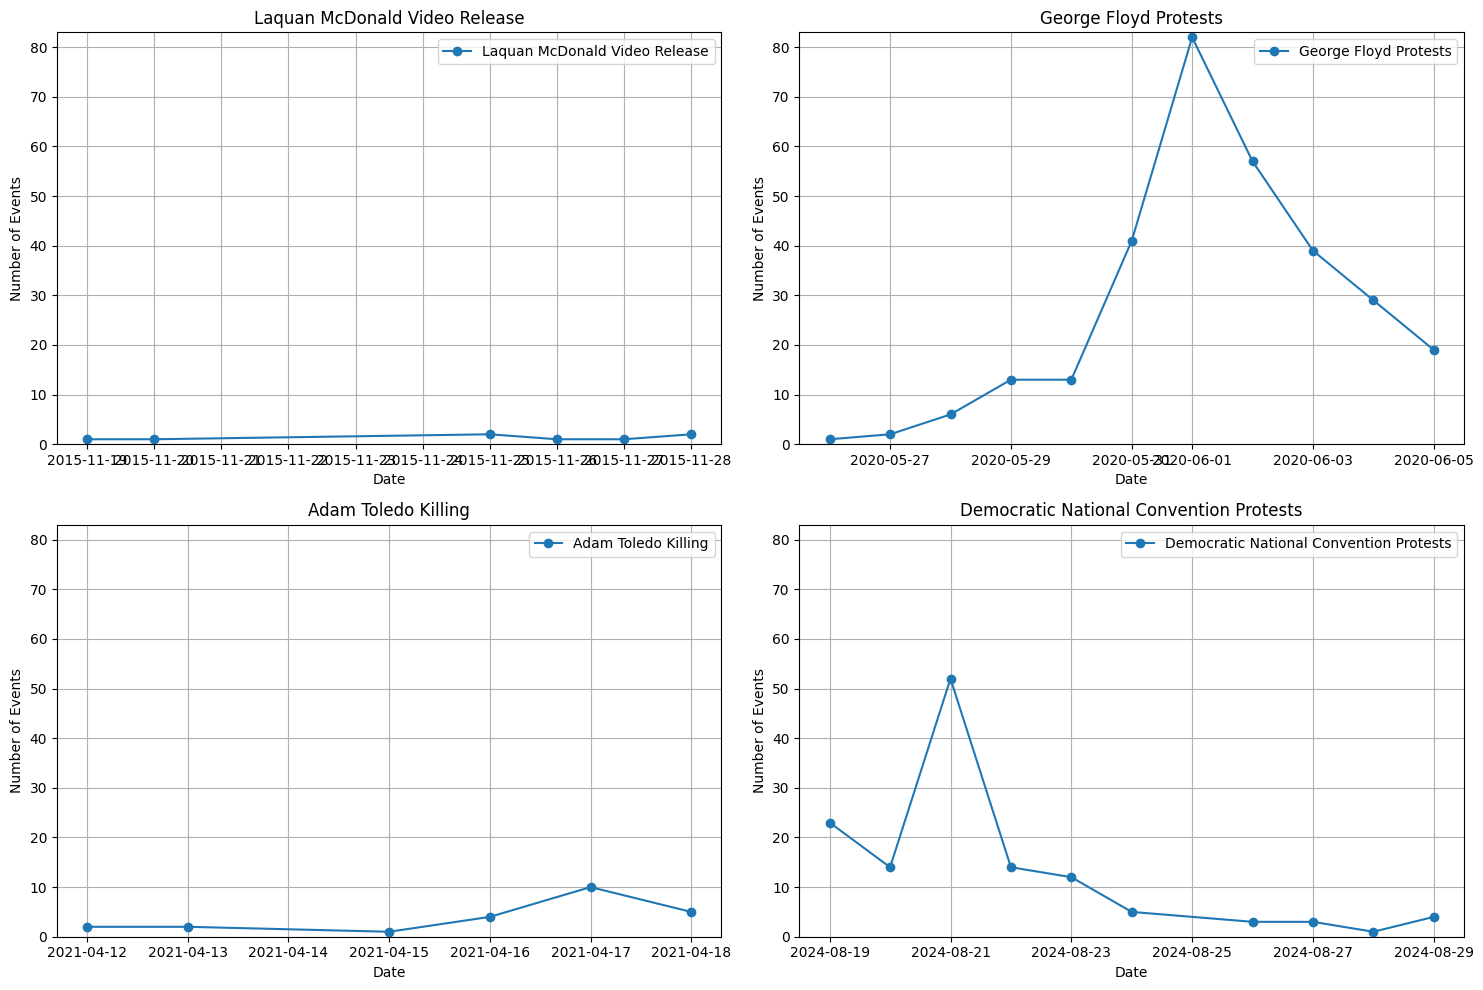

In [ ]:
# Define the specific events and their dates
events = {
    "Laquan McDonald Video Release": "2015-11-24",
    "George Floyd Protests": "2020-05-31",
    "Adam Toledo Killing": "2021-04-13",
    "Democratic National Convention Protests": "2024-08-24"
}

# Convert event dates to datetime
events = {event: pd.to_datetime(date) for event, date in events.items()}

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

# Determine the y-axis limits based on the maximum number of events in any window
max_events = 0
for event, date in events.items():
    window_data = data[(data['SQLDATE'] >= date - pd.Timedelta(days=5)) & (data['SQLDATE'] <= date + pd.Timedelta(days=5))]
    max_events = max(max_events, window_data.groupby('SQLDATE').size().max())

for ax, (event, date) in zip(axes, events.items()):
    # Filter data for the 10-day window around the event
    window_data = data[(data['SQLDATE'] >= date - pd.Timedelta(days=5)) & (data['SQLDATE'] <= date + pd.Timedelta(days=5))]
    
    # Group data and ensure alignment
    grouped_data = window_data.groupby('SQLDATE').size()
    ax.plot(grouped_data.index, grouped_data.values, marker='o', label=event)
    ax.set_title(event)
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of Events')
    ax.set_ylim(0, max_events + 1)  # Set the same y-axis limits for all subplots
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

---

It looks like half of these events were captured. With the George Floyd and DNC events being more significant, I feel confident this data is still good; however, this is where we would refine the model to define the labels better in the future.

---